In [1]:
# Initialize
from random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
torch.set_printoptions(precision=8)

# Printing Options
class designer:
    purple = '\033[95m'
    green = '\033[92m'
    red = '\033[91m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

if torch.cuda.is_available() == True:
    device = torch.device("cuda")
else:
    deivce = torch.device("cpu")

In [2]:
# Load Data
train_set = torchvision.datasets.MNIST(
    root='',
    train=True, 
    download=False, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)), # Resize image to fit LeNet-5
        transforms.ToTensor() # Convert PIL.Images to torch.tensors
    ])
)

dev_set = torchvision.datasets.MNIST(
    root='', 
    train=False, 
    download=False, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)), 
        transforms.ToTensor()
    ])
)

In [3]:
class ConvNet5(nn.Module):
    def __init__(self):
        super(ConvNet5, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 8, 5) # ConvLayer 1 -> 1 input channel, 6 output channels, f=(5 x 5)
        self.conv1_bn = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 32, 5) # ConvLayer 2 -> 6 input channels, 16 output channels, f=(5 x 5) 
        self.conv2_dp = nn.Dropout2d(0.4) # Dropout - keep_prob = 0.3
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(800, 256) # Fully connected layer 1 -> 400 | 120
        self.fc1_dp = nn.Dropout(0.4) # Dropout - keep_prob = 0.4
        self.fc2 = nn.Linear(256, 84) # Fully connected layer 2 -> 120 | 84
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10) # Output
        
    def forward(self, X):
        A = F.relu(F.max_pool2d(self.conv1_bn(self.conv1(X)), 2)) # ReLU(Max_Pool()) -> stride=2
        A = F.relu(F.max_pool2d(self.conv2_dp(self.conv2(A)), 2)) # ReLU(Max_Pool()) -> stride=2
        
        A = A.view(A.size()[0], -1) # Unroll the activation
        
        A = F.relu(self.fc1_dp(self.fc1(A))) # ReLU Activation on FC layer 1
        A = F.relu(self.fc2_bn(self.fc2(A))) # ReLU Activation on FC layer 2
        A = self.fc3(A) # Output
        
        return A
    
model = ConvNet5().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.0033) # optimizer -> ADAM
scheduler = StepLR(optimizer, step_size=2, gamma=0.79433)
criterion = nn.CrossEntropyLoss() # loss function -> Cross-Entropy Loss
counter = 0 # Set iteration counter to 0

ConvNet5(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_dp): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc1_dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
# Train
model.train()

constant = 1000 # interval for printing cost
epochs = 70 # number of epochs
epoch_constant = 20 # interval for printing epoch

for e in range(epochs):
    if e % epoch_constant == 0: print(designer.green + designer.bold + "Epoch " + str(e) + ":" + designer.end)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True, num_workers=4)
    for batch in train_loader:
        X = batch[0].to(device)
        y = batch[1].to(device)
        model.zero_grad()
        
        hypothesis = model(X)
        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()
        
        if counter % constant == 0:
            print("Cost on iteration " + str(counter) + ": " + str(round(cost.item(), 5)))
        counter += 1
    
    scheduler.step()
if counter % constant != 0: print(designer.bold + "Cost on final iteration: " + str(cost.item()) + designer.end)

Epoch 0:
Cost on iteration 0: 2.39416
Cost on iteration 1000: 0.06976
Cost on iteration 2000: 0.02448
Epoch 20:
Cost on iteration 3000: 0.0144
Cost on iteration 4000: 0.0168
Epoch 40:
Cost on iteration 5000: 0.00925
Cost on iteration 6000: 0.00215
Cost on iteration 7000: 0.01486
Epoch 60:
Cost on iteration 8000: 0.00391
Cost on final iteration: 0.010450762696564198


In [5]:
# Evaluate
model.eval()

# Train Evaluation
examples = 60000
counter = 0
for i in tqdm(range(examples)):
    X = train_set[i][0].to(device)
    y = train_set[i][1]
    
    if model(X.view(1, 1, 32, 32)).argmax(1).item() == y:
        counter += 1
train_accuracy = counter / examples

# CV Evaluation
examples = 10000
counter = 0
for i in tqdm(range(examples)):
    X = dev_set[i][0].to(device)
    y = dev_set[i][1]
    
    if model(X.view(1, 1, 32, 32)).argmax(1).item() == y:
        counter += 1
dev_accuracy = counter / examples

print("Train Accuracy: " + str(round(train_accuracy * 100, 5)) + "%")
print("Dev Accuracy: " + str(round(dev_accuracy * 100, 5)) + "%")

100%|██████████| 10000/10000 [00:09<00:00, 1035.75it/s]

Train Accuracy: 99.96333%
Dev Accuracy: 99.55%


Example 349:
The target(3) is equal to the hypothesis(3).


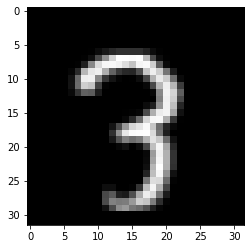

In [6]:
model.eval()
def mnister(x):
    print(designer.purple + designer.bold + designer.underline + "Example " + str(x) + ":" + designer.end)
    
    hypothesis = model(dev_set[x][0].view(1, 1, 32, 32).to(device)).argmax(1).item()
    target = dev_set[x][1]
    if target == hypothesis:
        print(designer.green+designer.bold+"The target("+str(target)+") is equal to the hypothesis("+str(hypothesis)+")."+designer.end)
    else:
        print(designer.red+designer.bold+"The target("+str(target)+") is not equal to the hypothesis("+str(hypothesis)+")."+designer.end)
        
    plt.imshow(dev_set[x][0].squeeze(), cmap="gray")
    return plt.show()

mnister(randint(1, 10000))

In [7]:
torch.save(model.state_dict(), 'MNIST.prm')